In [ ]:
import os
import glob
import torch
import random
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
from torch.nn.utils.rnn import pad_sequence

# Set environment variables to avoid library conflicts and configure CUDA
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE" 
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8" 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 



# 数据预处理

In [ ]:
# Function to check if a file corresponds to the left side ("L")
def is_left_file(filename):
    return os.path.basename(filename).startswith("L")

# Function to find columns with all zeros in trajectory CSV files within a folder
def find_all_zero_columns(folder):
    files = glob.glob(os.path.join(folder, '*_trajectory.csv')) 
    all_zero_cols = set() 

    for file in files:
        is_left = is_left_file(file) # Check if the file is for the left side
        prefix = 'L' if is_left else 'R' # Prefix for columns based on side (L or R)

        df = pd.read_csv(file)
        relevant_cols = [col for col in df.columns if col.startswith(prefix)]

        df_subset = df[relevant_cols]
        zero_cols = df_subset.columns[(df_subset == 0).all()].tolist()
        all_zero_cols.update(zero_cols)

    return all_zero_cols

# Identify markers with all-zero values across training and validation datasets and merge results
train_zero_cols = find_all_zero_columns('random_dataset/train')
val_zero_cols = find_all_zero_columns('random_dataset/val')
merged_zero_cols = sorted(train_zero_cols.union(val_zero_cols))

print("Markers with all zero:")
print(', '.join(merged_zero_cols))

# remove L(R)KNM, L(R)MED, L(R)SHO, L(R)SMH

Markers with all zero:
LKNM_X, LKNM_X', LKNM_X'', LKNM_Y, LKNM_Y', LKNM_Y'', LKNM_Z, LKNM_Z', LKNM_Z'', LMED_X, LMED_X', LMED_X'', LMED_Y, LMED_Y', LMED_Y'', LMED_Z, LMED_Z', LMED_Z'', LSMH_X, LSMH_X', LSMH_X'', LSMH_Y, LSMH_Y', LSMH_Y'', LSMH_Z, LSMH_Z', LSMH_Z'', RKNM_X, RKNM_X', RKNM_X'', RKNM_Y, RKNM_Y', RKNM_Y'', RKNM_Z, RKNM_Z', RKNM_Z'', RMED_X, RMED_X', RMED_X'', RMED_Y, RMED_Y', RMED_Y'', RMED_Z, RMED_Z', RMED_Z'', RSHO_X, RSHO_X', RSHO_X'', RSHO_Y, RSHO_Y', RSHO_Y'', RSHO_Z, RSHO_Z', RSHO_Z'', RSMH_X, RSMH_X', RSMH_X'', RSMH_Y, RSMH_Y', RSMH_Y'', RSMH_Z, RSMH_Z', RSMH_Z''


In [ ]:

# ========== Data Loading Functions ==========

# Define excluded and fixed marker points for trajectory processing
EXCLUDED_POINTS = ['LFHD', 'RFHD', 'LBHD', 'RBHD', 'C7', 'T10', 'CLAV', 'RBAK'] # Markers to exclude
NUM_FEATURES = 9 # Number of features per marker (position, velocity, acceleration in 3D)
FIXED_POINTS = ['LANK', 'LHEE', 'LKNE', 'LTOE', 'LTHI', 'LTIAD', 'LTIAP', 'LTIB', 'LTHAD', 'LTHAP', 'LPSI', 'LASI', 'LFMH', 'LVMH', 
                'RANK', 'RHEE', 'RKNE', 'RTOE', 'RTHI', 'RTIAD', 'RTIAP', 'RTIB', 'RTHAD', 'RTHAP', 'RPSI', 'RASI', 'RFMH', 'RVMH'] # Fixed marker points for left (L) and right (R) sides

def is_left_file(filename):
    return os.path.basename(filename).startswith("L")

# Function to pair trajectory and model files based on matching filenames
def pair_files(folder_path):
    traj_files = sorted(glob.glob(os.path.join(folder_path, '*_trajectory.csv')))
    model_files = sorted(glob.glob(os.path.join(folder_path, '*_model.csv')))
    pairs = [] 
    for traj in traj_files:
        base = os.path.basename(traj).replace('_trajectory.csv', '')
        model = os.path.join(folder_path, base + '_model.csv')
        if os.path.exists(model):
            pairs.append((traj, model))
    return pairs

# Function to read trajectory data from a CSV file and format it into tensors
def read_trajectory(traj_path, is_left, selected_markers=None):
    df = pd.read_csv(traj_path)
    suffixes = ['X', 'Y', 'Z', "X'", "Y'", "Z'", "X''", "Y''", "Z''"] # Suffixes for marker features
    prefix = 'L' if is_left else 'R' # Prefix for left or right side

    if selected_markers is not None:
        point_list = [f"{prefix}{m}" for m in selected_markers] # Prefix selected markers
    else:
        point_list = [p for p in FIXED_POINTS if p.startswith(prefix)] # Use fixed points for the side

    # Select relevant columns and reshape data for model input
    cols = [f"{p}_{s}" for p in point_list for s in suffixes if f"{p}_{s}" in df.columns]
    X = df[cols].values.reshape(-1, len(point_list), NUM_FEATURES) # Reshape to (T, N, D)
    return X

# Function to read Knee Adduction Moment (KAM) values from model file
def read_kam(model_path, is_left):
    df = pd.read_csv(model_path)
    col = 'LKneeMoment_Y' if is_left else 'RKneeMoment_Y'
    return df[col].values

# ========== Dataset Class ==========

# Custom PyTorch Dataset class for loading KAM data
class KAMDataset(torch.utils.data.Dataset):
    def __init__(self, folder_path, selected_markers=None):
        self.data = [] # List to store dataset samples
        pairs = pair_files(folder_path) # Pair trajectory and model files

        for traj_path, model_path in pairs:
            is_left = is_left_file(traj_path)

            X = read_trajectory(traj_path, is_left, selected_markers)
            Y = read_kam(model_path, is_left)

            input_tensor = torch.tensor(X, dtype=torch.float32)
            target_tensor = torch.tensor(Y, dtype=torch.float32)
            filename = os.path.basename(model_path)

            self.data.append({
                'input': input_tensor,
                'target': target_tensor,
                'filename': filename
            })

        self.selected_markers = selected_markers # Store selected markers
        print(f"Loaded {len(self.data)} samples (using {X.shape[1]} markers)")

    def __len__(self):
        return len(self.data) # Return dataset size

    def __getitem__(self, idx):
        return self.data[idx] # Return dataset sample

# ========== collate_fn ==========

# Custom collate function for handling variable-length sequences in a batch
def collate_fn(batch):
    inputs = [item['input'] for item in batch]
    targets = [item['target'] for item in batch]
    lengths = [x.shape[0] for x in inputs]
    max_len = max(lengths)

    # Pad sequences to uniform length
    padded_inputs = pad_sequence(inputs, batch_first=True)  # (B, T, N, D)
    padded_targets = pad_sequence([y.unsqueeze(-1) for y in targets], batch_first=True).squeeze(-1)  # (B, T)

    # Create padding mask to indicate valid frames
    mask = torch.zeros((len(batch), max_len), dtype=torch.bool)
    for i, l in enumerate(lengths):
        mask[i, :l] = 1

    return padded_inputs, padded_targets, mask

# ========== Model Definitions ==========

# Frame-wise encoder for PointNet to extract spatial features from 3D marker data
class PointNetFrameEncoder(nn.Module):
    def __init__(self, input_dim=9, hidden_dim=256):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, 64), nn.ReLU(), nn.BatchNorm1d(64),
            nn.Linear(64, 128), nn.ReLU(), nn.BatchNorm1d(128),
            nn.Linear(128, hidden_dim), nn.ReLU(), nn.BatchNorm1d(hidden_dim),
        )

    def forward(self, x):  # Input: (B, T, N, D)
        B, T, N, D = x.shape
        x = x.reshape(B * T * N, D)
        x = self.mlp(x)
        x = x.view(B * T, N, -1)
        x = torch.max(x, dim=1)[0]  
        return x.view(B, T, -1)  # Reshape to (B, T, hidden_dim)

# Combined PointNet + Transformer model for KAM prediction
class PointNetTransformerRegressor(nn.Module):
    def __init__(self, input_dim=9, point_feat_dim=256, trans_hidden=256, nhead=8, num_layers=3):
        super().__init__()
        self.encoder = PointNetFrameEncoder(input_dim, point_feat_dim) # Spatial encoding for each frame

        # Transformer encoder for temporal modeling across frames
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=point_feat_dim,
            nhead=nhead,
            dim_feedforward=trans_hidden,
            dropout=0.2,
            batch_first=True,
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Regression head: Converts Transformer outputs to KAM values
        self.head = nn.Sequential(
            nn.Linear(point_feat_dim, 128), nn.ReLU(), nn.BatchNorm1d(128), nn.Dropout(0.2),
            nn.Linear(128, 64), nn.ReLU(), nn.BatchNorm1d(64), nn.Dropout(0.2),
            nn.Linear(64, 1) # Final output: Single KAM value per frame
        )

    def forward(self, x, mask):
        """
        x: (B, T, N, D)
        mask: (B, T) with bool values: True for valid, False for pad
        """
        feat = self.encoder(x)  # Frame-level spatial encoding (B, T, F)
        key_padding_mask = ~mask  # Invert mask for Transformer (True for padding)

        trans_out = self.transformer(feat, src_key_padding_mask=key_padding_mask)  # Temporal modeling (B, T, F)

        B, T, F = trans_out.shape
        out = self.head(trans_out.reshape(B * T, F)).reshape(B, T)  

        return out * mask  # apply mask to ensure padding has no prediction

# ========== Loss Function ==========

# Custom Mean Squared Error (MSE) loss that applies a mask to ignore padding
def masked_mse_loss(pred, target, mask):
    loss = F.mse_loss(pred, target, reduction='none')
    return (loss * mask).sum() / mask.sum()

# ========== Training Function ==========

# Function to train the model on the training set and evaluate on the validation set
def train_model(model, train_loader, val_loader, epochs=500, lr=1e-3, patience=50, save_path='best_model.pth'):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    best_loss = float('inf')
    patience_counter = 0
    train_losses, val_losses = [], []

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        for x, y, m in train_loader:
            x = x.to(device)
            y = y.to(device)
            m = m.to(device)
            pred = model(x, m)
            loss = masked_mse_loss(pred, y, m)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for x, y, m in val_loader:
                x = x.to(device)
                y = y.to(device)
                m = m.to(device)
                pred = model(x, m)
                loss = masked_mse_loss(pred, y, m)
                total_val_loss += loss.item()

        # Compute average losses
        train_loss = total_train_loss / len(train_loader)
        val_loss = total_val_loss / len(val_loader)
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        # Save model if validation loss improves
        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(model.state_dict(), save_path)
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    # Plot loss curves
    plt.plot(train_losses, label='Train')
    plt.plot(val_losses, label='Val')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss Curve')
    plt.savefig('loss_curve.png')
    plt.close()

# ========== Evaluation Function ==========

# Function to evaluate the model on the test set and visualize predictions
def evaluate_model(model, test_loader, save_dir='results'):
    os.makedirs(save_dir, exist_ok=True)
    model.eval()
    total_mse, total_frames = 0, 0

    with torch.no_grad():
        for i, (x, y, m) in enumerate(test_loader):
            x = x.to(device)
            y = y.to(device)
            m = m.to(device)
            pred = model(x, m)
            for b in range(x.size(0)):
                T = int(m[b].sum().item())
                gt = y[b][:T].cpu().numpy()
                pr = pred[b][:T].cpu().numpy()
                mse = np.mean((gt - pr) ** 2)
                total_mse += mse * T
                total_frames += T

                # Plot ground truth vs. prediction for each sample
                plt.figure()
                plt.plot(gt, label='GT')
                plt.plot(pr, label='Pred')
                plt.xlabel('Frame')
                plt.ylabel('KAM')
                plt.title(f'Sample {i*test_loader.batch_size + b}, MSE: {mse:.4f}')
                plt.legend()
                plt.savefig(os.path.join(save_dir, f'sample_{i*test_loader.batch_size + b}.png'))
                plt.close()

    avg_mse = total_mse / total_frames # Compute average MSE across all frames
    print(f"Test MSE: {avg_mse:.6f}")

# ========== Reproducibility ==========

# Function to set a fixed random seed for reproducibility
def set_seed(seed=5703):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.use_deterministic_algorithms(True)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [ ]:
# Function to compute saliency maps for identifying important markers
def compute_saliency_map_symmetric(model, dataloader, device='cuda', num_samples=2000):
    model = model.to(device)
    model.eval()
    saliency_accum = None
    total_valid_frames = 0

    for x, y, m in dataloader:
        if total_valid_frames >= num_samples:
            break

        x = x.to(device).detach().requires_grad_(True)  # (B, T, N, D)
        m = m.to(device)  # (B, T)

        output = model(x, m)  # (B, T)
        loss = output.sum()
        loss.backward()

        grad = x.grad.detach()  # (B, T, N, D)

        # Expand the mask to match input dimensions and apply it to the gradients
        mask_expanded = m.unsqueeze(-1).unsqueeze(-1).float()
        grad = grad * mask_expanded  

        grad_abs = grad.abs()
        grad_sum = grad_abs.sum(dim=(1, 3))  # Sum gradients across time (T) and dimensions (D)

        if saliency_accum is None:
            saliency_accum = grad_sum.sum(dim=0)  
        else:
            saliency_accum += grad_sum.sum(dim=0)

        total_valid_frames += m.sum().item()  

    # Normalize saliency by total valid frames, not total samples
    saliency = saliency_accum.cpu().numpy() / total_valid_frames
    saliency = saliency / saliency.sum()  # normalize to sum 1

    # Merge saliency scores for symmetric markers (e.g., left/right) 
    N = saliency.shape[0]

    left_markers = [p for p in FIXED_POINTS if p.startswith('L')]
    right_markers = [p for p in FIXED_POINTS if p.startswith('R')]

    # Determine whether the markers are left or right based on their count
    if N == len(left_markers):
        marker_names = left_markers
    elif N == len(right_markers):
        marker_names = right_markers
    else:
        raise ValueError("Unable to determine marker side.")

    # Group saliency scores by symmetric marker names (e.g., LANK and RANK → ANK)
    suffix_dict = {}
    for name, value in zip(marker_names, saliency):
        suffix = name[1:]  
        suffix_dict.setdefault(suffix, []).append(value)

    # Compute the average saliency score for each symmetric marker
    merged_saliency = {k: np.mean(v) for k, v in suffix_dict.items()}
    return merged_saliency


# 加载数据，初始化模型

In [5]:
set_seed(5703)

# Load dataset splits
train_set = KAMDataset(os.path.join('random_dataset', 'train'))
val_set = KAMDataset(os.path.join('random_dataset', 'val'))
test_set = KAMDataset(os.path.join('random_dataset', 'test'))

print(f"Training samples: {len(train_set)}, Validation samples: {len(val_set)}, Test samples: {len(test_set)}")

# Create DataLoaders
train_loader = DataLoader(train_set, batch_size=64, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_set, batch_size=64, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_set, batch_size=16, shuffle=False, collate_fn=collate_fn)

# Train baseline model using all markers
model = PointNetTransformerRegressor().to(device)
print(f"Model is running on: {next(model.parameters()).device}")
train_model(model, train_loader, val_loader, save_path='baseline_all_marker.pth')


Loaded 2336 samples (using 14 markers)
Loaded 292 samples (using 14 markers)
Loaded 292 samples (using 14 markers)
Training samples: 2336, Validation samples: 292, Test samples: 292
Model is running on: cuda:0


d:\anaconda\anaconda\envs\5329\Lib\site-packages\torch\nn\modules\transformer.py:505: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\NestedTensorImpl.cpp:182.)
  output = torch._nested_tensor_from_mask(


Epoch 1, Train Loss: 2.8283, Val Loss: 2.2347
Epoch 2, Train Loss: 1.6628, Val Loss: 1.9879
Epoch 3, Train Loss: 1.3721, Val Loss: 1.2549
Epoch 4, Train Loss: 1.1137, Val Loss: 1.2670
Epoch 5, Train Loss: 1.0010, Val Loss: 0.9705
Epoch 6, Train Loss: 0.9489, Val Loss: 2.1571
Epoch 7, Train Loss: 0.8669, Val Loss: 0.7258
Epoch 8, Train Loss: 0.8046, Val Loss: 0.7587
Epoch 9, Train Loss: 0.7340, Val Loss: 0.7550
Epoch 10, Train Loss: 0.7194, Val Loss: 0.9128
Epoch 11, Train Loss: 0.5837, Val Loss: 0.7028
Epoch 12, Train Loss: 0.6084, Val Loss: 1.0881
Epoch 13, Train Loss: 0.5737, Val Loss: 0.6322
Epoch 14, Train Loss: 0.5379, Val Loss: 0.7440
Epoch 15, Train Loss: 0.5271, Val Loss: 1.1074
Epoch 16, Train Loss: 0.5120, Val Loss: 0.7407
Epoch 17, Train Loss: 0.4452, Val Loss: 0.5827
Epoch 18, Train Loss: 0.4467, Val Loss: 0.5179
Epoch 19, Train Loss: 0.4123, Val Loss: 0.6876
Epoch 20, Train Loss: 0.3834, Val Loss: 0.5322
Epoch 21, Train Loss: 0.4235, Val Loss: 0.5453
Epoch 22, Train Loss: 

# 计算marker重要性

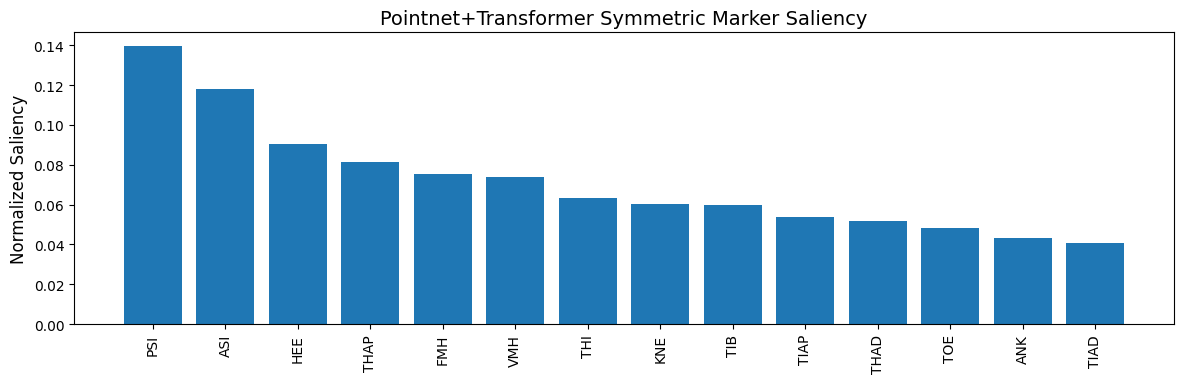

Top influential symmetric markers:
PSI: 0.1395
ASI: 0.1180
HEE: 0.0906
THAP: 0.0812
FMH: 0.0756
VMH: 0.0736
THI: 0.0633
KNE: 0.0601
TIB: 0.0599
TIAP: 0.0539


In [ ]:
# ========== Saliency Analysis and Visualization ==========

set_seed(5703)

import matplotlib.pyplot as plt

plt.rcParams.update({
    'figure.dpi': 100,
    'savefig.dpi': 100,
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.figsize': (12, 4),
})

# Load trained model and compute saliency map
model.load_state_dict(torch.load('baseline_all_marker.pth'))
model.eval()
merged_saliency = compute_saliency_map_symmetric(model, val_loader, device=device)

# Visualize saliency map
sorted_items = sorted(merged_saliency.items(), key=lambda x: -x[1])
labels, values = zip(*sorted_items)

# Plot saliency scores for markers
plt.figure()
plt.bar(labels, values, color='tab:blue')  
plt.xticks(rotation=90)
plt.ylabel("Normalized Saliency")
plt.title("Pointnet+Transformer Symmetric Marker Saliency")
plt.tight_layout()
plt.savefig("merged_saliency.png")
plt.show()


# Print the top 10 most influential symmetric markers
print("Top influential symmetric markers:")
for name, score in sorted_items[:10]:
    print(f"{name}: {score:.4f}")


# marker筛选

In [ ]:
# ========== Evaluate Marker Combinations for Model Performance ==========

# Function to evaluate model performance with different subsets of markers based on saliency scores
def evaluate_marker_combinations(
    saliency_dict,
    top_k_list,
    root_dir='random_dataset',
    epochs=500,
    patience=50,
    all_marker_result=None,
    final_model_path='best_marker_combination.pth'
):
    """
    Evaluate model performance with different top-k marker subsets selected by saliency.

    Args:
        saliency_dict (dict): Symmetric saliency scores, e.g., {'ANK': 0.12, ...}
        top_k_list (list): List of k values for top-k marker selection, e.g., [4, 6, 11]
        root_dir (str): Path to dataset root folder containing 'train' and 'val'
        epochs (int): Maximum number of training epochs
        patience (int): Early stopping patience
        all_marker_result (float or None): Optional val loss of all-marker model for comparison
        final_model_path (str): Path to save the best-performing model

    Returns:
        results (list): List of tuples (Top-k name, selected suffixes, val loss)
    """
    results = [] 
    sorted_markers = sorted(saliency_dict.items(), key=lambda x: -x[1])
    best_model_file = None

    # Iterate through the specified top-k subsets
    for k in top_k_list:
        selected_suffixes = [name for name, _ in sorted_markers[:k]]
        print(f"\n Training with Top-{k} markers: {selected_suffixes}")

        # Prepare datasets and loaders
        train_set = KAMDataset(os.path.join(root_dir, 'train'), selected_suffixes)
        val_set = KAMDataset(os.path.join(root_dir, 'val'), selected_suffixes)

        train_loader = DataLoader(train_set, batch_size=64, shuffle=True, collate_fn=collate_fn)
        val_loader = DataLoader(val_set, batch_size=64, shuffle=False, collate_fn=collate_fn)

        # Train model
        model = PointNetTransformerRegressor()
        model_save_path = f"pointnet_transformer_top_{k}.pth"
        train_model(model, train_loader, val_loader, epochs=epochs, patience=patience, save_path=model_save_path)
        model.load_state_dict(torch.load(model_save_path))

        # Evaluate validation loss
        model.eval()
        total_val_loss = 0
        total_count = 0
        with torch.no_grad():
            for x, y, m in val_loader:
                x = x.to(device)
                y = y.to(device)
                m = m.to(device)
                pred = model(x, m)
                loss = masked_mse_loss(pred, y, m)
                total_val_loss += loss.item() * x.size(0)
                total_count += x.size(0)

        avg_val_loss = total_val_loss / total_count 
        results.append((f"Top-{k}", selected_suffixes, avg_val_loss))
        print(f"Top-{k} markers Val Loss: {avg_val_loss:.6f}")

        # Track the best model file based on validation loss
        if best_model_file is None or avg_val_loss < min([r[2] for r in results[:-1]]):
            best_model_file = model_save_path

    # Add all-marker baseline result (if provided)
    if all_marker_result is not None:
        results.append(("All", "All markers", all_marker_result))
        print(f"\n Included all markers baseline Val Loss: {all_marker_result:.6f}")

    # Report the best-performing marker combination
    best = min(results, key=lambda x: x[2]) # Find the combination with the lowest validation loss
    print("\n Best marker combination:")
    print(f"{best[0]} markers: {best[1]}")
    print(f"Val Loss: {best[2]:.6f}")

    # Save best model
    if best_model_file is not None:
        import shutil
        shutil.copyfile(best_model_file, final_model_path)
        print(f" Best model saved to: {final_model_path}")

    return results, best[1]


In [ ]:
# ========== Evaluate Top Marker Combinations ==========

set_seed(5703)

# Evaluate model performance with different top-k marker subsets
results, best_markers = evaluate_marker_combinations(
    merged_saliency,
    top_k_list=[4, 6, 9, 12, 14],
    all_marker_result=None,
    final_model_path='best_marker_combination.pth'
)

# ========== Test Best Model on Test Set ==========

# Load the best-performing model
model = PointNetTransformerRegressor().to(device)
model.load_state_dict(torch.load('best_marker_combination.pth', map_location=device))
model.eval()  

test_set = KAMDataset('random_dataset/test', selected_markers=best_markers)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False, collate_fn=collate_fn)

# Evaluate the model on the test set
evaluate_model(model, test_loader)



 Training with Top-4 markers: ['PSI', 'ASI', 'HEE', 'THAP']
Loaded 2336 samples (using 4 markers)
Loaded 292 samples (using 4 markers)
Epoch 1, Train Loss: 2.6580, Val Loss: 3.0285
Epoch 2, Train Loss: 1.6488, Val Loss: 2.4494
Epoch 3, Train Loss: 1.3499, Val Loss: 1.3062
Epoch 4, Train Loss: 1.1033, Val Loss: 1.0917
Epoch 5, Train Loss: 0.9577, Val Loss: 0.8492
Epoch 6, Train Loss: 0.9215, Val Loss: 1.3821
Epoch 7, Train Loss: 0.8208, Val Loss: 0.8045
Epoch 8, Train Loss: 0.8081, Val Loss: 1.1928
Epoch 9, Train Loss: 0.7415, Val Loss: 0.7168
Epoch 10, Train Loss: 0.7223, Val Loss: 0.7091
Epoch 11, Train Loss: 0.5898, Val Loss: 0.6816
Epoch 12, Train Loss: 0.5955, Val Loss: 1.0788
Epoch 13, Train Loss: 0.5244, Val Loss: 0.5938
Epoch 14, Train Loss: 0.4770, Val Loss: 0.9954
Epoch 15, Train Loss: 0.4680, Val Loss: 0.5683
Epoch 16, Train Loss: 0.4394, Val Loss: 0.8742
Epoch 17, Train Loss: 0.4087, Val Loss: 0.5817
Epoch 18, Train Loss: 0.4205, Val Loss: 0.6364
Epoch 19, Train Loss: 0.360

In [ ]:
# ========== Visualize Average KAM Curves ==========

# Function to plot average predicted vs. ground truth KAM curves
def plot_average_kam_curve(model, dataset, device='cuda', save_path=None, show=True):
    import matplotlib.pyplot as plt

    model = model.to(device)
    model.eval()

    all_true = []
    all_pred = []

    max_length = 0
    for idx in range(len(dataset)):
        sample = dataset[idx]
        x = sample['input'].unsqueeze(0).to(device)
        y = sample['target'].unsqueeze(0).to(device)
        T = x.shape[1]
        mask = torch.ones((1, T), dtype=torch.bool).to(device)

        with torch.no_grad():
            pred = model(x, mask)

        true_kam = y.squeeze(0).cpu().numpy()
        pred_kam = pred.squeeze(0).cpu().numpy()
        length = min(len(true_kam), len(pred_kam))
        max_length = max(max_length, length)

        all_true.append(true_kam[:length])
        all_pred.append(pred_kam[:length])

    # Pad all sequences to the maximum length with NaN
    def pad_with_nan(seq_list, max_len):
        return np.array([
            np.pad(seq, (0, max_len - len(seq)), constant_values=np.nan)
            for seq in seq_list
        ])

    all_true_padded = pad_with_nan(all_true, max_length)
    all_pred_padded = pad_with_nan(all_pred, max_length)

    # Compute mean curves over valid (non-NaN) values
    mean_true_curve = np.nanmean(all_true_padded, axis=0)
    mean_pred_curve = np.nanmean(all_pred_padded, axis=0)

    # Plot the mean curves
    plt.figure(figsize=(10, 5))
    plt.plot(mean_true_curve, label='Mean Ground Truth', linewidth=2)
    plt.plot(mean_pred_curve, label='Mean Prediction', linestyle='--')
    plt.xlabel('Frame')
    plt.ylabel('KAM')
    plt.title('Pointnet+transformer Mean KAM Curve Across All Samples')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path)
        plt.close()
    elif show:
        plt.show()


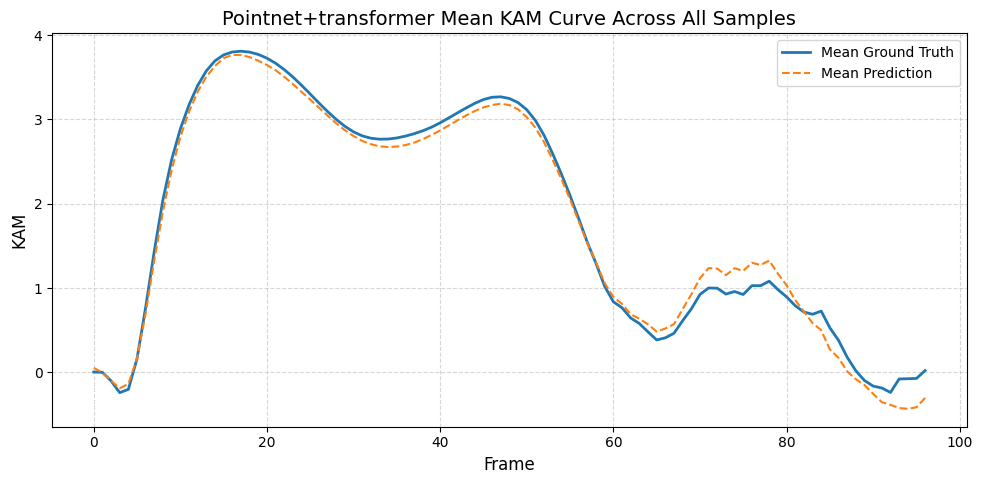

In [ ]:
# Plot the average KAM curve for the test set
plot_average_kam_curve(model, test_set, device='cuda')


In [ ]:
# ========== Extract Peak KAM Metrics ==========

# Function to extract peak KAM values and their prediction errors
def extract_peak_kam_metrics(model, dataset, save_csv_path='results/peak_kam_summary.csv', device=device):
    model = model.to(device)
    model.eval()
    records = []

    for idx in range(len(dataset)):
        sample = dataset[idx]
        x = sample['input'].unsqueeze(0).to(device)      # (1, T, N, D)
        y = sample['target'].unsqueeze(0).to(device)     # (1, T)
        T = x.shape[1]
        mask = torch.ones((1, T), dtype=torch.bool).to(device)
        filename = sample['filename']

        with torch.no_grad():
            pred = model(x, mask)  # (1, T)

        # Extract KAM values
        pred_kam = pred.squeeze(0).cpu().numpy()
        true_kam = y.squeeze(0).cpu().numpy()

        # Split sequence into two halves to identify the first and second peaks
        mid = T // 2
        true_kam1 = np.max(true_kam[:mid]) if mid > 0 else np.nan
        true_kam2 = np.max(true_kam[mid:]) if mid < T else np.nan
        pred_kam1 = np.max(pred_kam[:mid]) if mid > 0 else np.nan
        pred_kam2 = np.max(pred_kam[mid:]) if mid < T else np.nan

        records.append({
            'n': filename,
            'peak KAM1 Actual': true_kam1,
            'peak KAM1 Predict': pred_kam1,
            'peak KAM2 Actual': true_kam2,
            'peak KAM2 Predict': pred_kam2,
        })

    # Save results to a CSV file
    df = pd.DataFrame(records)
    df.to_csv(save_csv_path, index=False)
    print(f"{save_csv_path}")
    return df


In [ ]:
from numpy import mean, std

# Calculate and save peak KAM metrics
df = extract_peak_kam_metrics(model, test_set, save_csv_path='results/peak_kam_summary.csv', device=device)

# Compute and print Mean Squared Errors (MSE) for the first and second peaks
kam1_mse = mean((df['peak KAM1 Actual'] - df['peak KAM1 Predict'])**2)
kam2_mse = mean((df['peak KAM2 Actual'] - df['peak KAM2 Predict'])**2)

print(f"Peak KAM1 MSE  → Mean = {kam1_mse:.3f}")
print(f"Peak KAM2 MSE  → Mean = {kam2_mse:.3f}")

results/peak_kam_summary.csv
Peak KAM1 MSE  → Mean = 0.547
Peak KAM2 MSE  → Mean = 0.458


In [ ]:
# ========== Save Full KAM Curves with Mapping Information ==========

import os
import pandas as pd
import torch

# Function to save full KAM curves with display names (mapped from a password file) and raw filenames
def save_kam_curves_with_password_names(model, dataset, 
                                        password_path='dataset_split_method/dataset_split_method/PASSWORD.csv',
                                        save_csv_path='results/full_kam_curve_prediction_vs_actual.csv', 
                                        save_rawname_csv_path='results/full_kam_curve_with_raw_filenames.csv',
                                        device='cuda'):
    # Load mapping file: Key = raw filename, ID = display name
    mapping = pd.read_csv(password_path)
    key_to_id = dict(zip(mapping['Key'], mapping['ID']))

    records = []         
    records_rawname = [] 
    skipped = []

    for idx in range(len(dataset)):
        sample = dataset[idx]
        x = sample['input'].unsqueeze(0).to(device)
        y = sample['target'].unsqueeze(0).to(device)
        mask = torch.ones((1, x.shape[1]), dtype=torch.bool).to(device)

        filename = sample['filename'].replace('.csv', '').replace('_model', '')

        if filename not in key_to_id:
            skipped.append(filename)
            continue

        display_name = key_to_id[filename]

        with torch.no_grad():
            pred = model(x, mask)

        gt = y.squeeze(0).cpu().numpy()
        pr = pred.squeeze(0).cpu().numpy()

        
        df_named = pd.DataFrame({
            f'{display_name} Actual': pd.Series(gt),
            f'{display_name} Predict': pd.Series(pr)
        })
        records.append(df_named)


        df_raw = pd.DataFrame({
            f'{filename} Actual': pd.Series(gt),
            f'{filename} Predict': pd.Series(pr)
        })
        records_rawname.append(df_raw)

    # Save display-name-mapped results
    df_all = pd.concat(records, axis=1)
    os.makedirs(os.path.dirname(save_csv_path), exist_ok=True)
    df_all.to_csv(save_csv_path, index=False)
    print(f"Saved full KAM curves with display names to: {save_csv_path}")

    # Save raw-filename-mapped results
    df_raw_all = pd.concat(records_rawname, axis=1)
    os.makedirs(os.path.dirname(save_rawname_csv_path), exist_ok=True)
    df_raw_all.to_csv(save_rawname_csv_path, index=False)
    print(f"Saved full KAM curves with raw filenames to: {save_rawname_csv_path}")


In [ ]:
# Save full KAM curves for the test set
save_kam_curves_with_password_names(
    model=model,
    dataset=test_set,
    password_path='dataset_split_method/dataset_split_method/PASSWORD.csv',
    save_csv_path='results/full_kam_curve_prediction_vs_actual.csv',
    device=device
)

Saved full KAM curves with display names to: results/full_kam_curve_prediction_vs_actual.csv
Saved full KAM curves with raw filenames to: results/full_kam_curve_with_raw_filenames.csv
